In [1]:
import tensorflow as tf
from tensorflow import keras
import random as rnd
import numpy as np
import math
import time
from IPython.display import clear_output

2022-08-02 12:07:52.172992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 12:07:52.173013: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/kimiya/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
from tensorflow.keras.optimizers import Adam

## Evironment

In [137]:
class environment:
    def __init__(self,map_size):
        self.map_size=map_size
        self.map=[[' ']*map_size for _ in range(map_size)]
        self.map[map_size//2][map_size//2]='s'
        self.head_loc=(map_size//2,map_size//2)
        self.tail_loc=self.head_loc
        self.action_set=[(1,0),(0,1),(-1,0),(0,-1)]
        self.dir_map={}
        self._spawn_food()
        
    def reset(self):
        self.map=[[' ']*self.map_size for _ in range(self.map_size)]
        self.map[self.map_size//2][self.map_size//2]='s'
        self.head_loc=(self.map_size//2,self.map_size//2)
        self.tail_loc=self.head_loc
        self.dir_map={}
        self._spawn_food()
        return self.get_state()

    def _spawn_food(self):
        while True:
            x=rnd.randint(1,len(self.map)-2)
            y=rnd.randint(1,len(self.map)-2)
            if self.map[x][y]==' ':
                self.map[x][y]='*'
                self.food_loc=(x,y)
                break
        
    def _get_reward(self,next_loc):
        if next_loc[0]== 0 or next_loc[1]==0 or next_loc[0]==len(self.map)-1 or next_loc[1]==len(self.map[0])-1:
            return 0
        next_element=self.map[next_loc[0]][next_loc[1]]
        if next_element=='s':
            return 0
        return (abs(self.head_loc[0]-self.food_loc[0])+abs(self.head_loc[1]-self.food_loc[1]))-(abs(next_loc[0]-self.food_loc[0])+abs(next_loc[1]-self.food_loc[1]))
#         if next_loc[0]== 0 or next_loc[1]==0 or next_loc[0]==len(self.map)-1 or next_loc[1]==len(self.map[0])-1:
#             return 0
#         next_element=self.map[next_loc[0]][next_loc[1]]
#         if next_element=='s':
#             return 0
#         if next_element==' ':
#             return 0
#         if next_element=='*':
#             return 1
        
#         return 0

    def get_state(self):
        state=[]
        for row in self.map:
            for block in row:
                if block ==' ':
                    state=state+[0,0,1]
                elif block=='s':
                    state=state+[0,1,0]
                elif block=='*':
                    state=state+[1,0,0]
        state+=[self.head_loc[0],self.head_loc[1]]
        return state
                
        
    def _update_map(self,next_loc):
        if next_loc[0]== 0 or next_loc[1]==0 or next_loc[0]==len(self.map)-1 or next_loc[1]==len(self.map[0])-1:
            return True
        next_element=self.map[next_loc[0]][next_loc[1]]
        if next_element=='s':
            return True
        
        self.map[next_loc[0]][next_loc[1]]='s'
        self.dir_map[self.head_loc]=next_loc
        self.head_loc=next_loc
        
        if next_element==' ':
            self.map[self.tail_loc[0]][self.tail_loc[1]]=' '
            self.tail_loc=self.dir_map[self.tail_loc]
            #self._set_new_tail_loc()
        if next_element=="*":
            self._spawn_food()
        
        return False
    
    def simulate_action(self,action):
        next_loc=tuple(map(sum, zip(self.head_loc, action)))
        reward=self._get_reward(next_loc)
        done=self._update_map(next_loc)
        return reward, self.get_state(), done

    def get_actions(self):
        return self.action_set
    
    def get_index(self,action):
        for i in range(len(self.action_set)):
            if self.action_set[i]==action:
                return i
        return 0
    
    def render(self):
        for i in range(len(self.map)):
            for j in range(len(self.map)):
                if i== 0 or j==0 or i==len(self.map)-1 or j==len(self.map[0])-1 or self.map[i][j]=='s':
                    print('■',end=' ')
                else:
                    print(self.map[i][j],end=' ')
            print('')


In [138]:
env=environment(10)
env.render()
for _ in range(10) :
    acts=env.get_actions()
    act=rnd.sample(acts,1)[0]
    _,_,done=env.simulate_action(act)
    clear_output(wait=True)
    print("current act=",act)
    env.render()
    #time.sleep(0.1)
    if done:
        env.reset()

current act= (0, -1)
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■               * ■ 
■                 ■ 
■                 ■ 
■                 ■ 
■                 ■ 
■       ■         ■ 
■                 ■ 
■                 ■ 
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 


In [139]:
def print_game():
    clear_output(wait=True)
    env.render()
    #time.sleep(1)

In [140]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [141]:
class DQN:
    def __init__(self,states):
        self._build_model(states)
        pass

    def _build_model(self,states):
        self.model= Sequential()
        self.model.add(Dense(24,input_shape=(len(states),),activation='relu'))
        self.model.add(Dense(24,activation='relu'))
        self.model.add(Dense(24,activation='relu'))
        self.model.add(Dense(4,activation='relu'))
        #self.model.summary()

        self.model.compile(optimizer=Adam(0.1),loss='mse')

    def predict(self, state):
        #print(state)
        return self.model.predict(state)

    def learn(self,state,target):
        #loss=self.model.fit(state,target,verbose=0,epochs=1)
        loss=self.model.fit(state,target,epochs=1)
        #print("loss=",loss)


    def set_weights(self,dqn_target):
        self.model.set_weights(dqn_target.model.get_weights())

    

In [142]:
class Replay_memory:
    def __init__(self,max_size):
        self.mem=[]
        self.max_size=max_size

    def store(self,state,action,reward,next_state):
        if len(self.mem) == self.max_size:
            self.mem.pop(0)

        self.mem.append((state,action,reward,next_state))
    
    def sample(self):
        return rnd.sample(self.mem,1)[0]
        

## Algorithm1

In [143]:
def choose_by_epsilon_greedy(env,state,epsilon,Q_fun):
    MAX_CHOICE=1
    RANDOM_CHOICE=0

    actions=env.get_actions()
    mode=rnd.choices([RANDOM_CHOICE,MAX_CHOICE], cum_weights=(epsilon,1), k=1)
    if mode==RANDOM_CHOICE:
        return rnd.sample(actions,1)[0]
    else:
        q_out=Q_fun.predict(np.array([np.array(state)]))
        arg_max=np.argmax(q_out)
        if np.min(q_out)==np.max(q_out):
            return rnd.sample(actions,1)[0]
        return actions[arg_max]
        


In [144]:
EPISODES=500
STEPS=100
STEPS_PER_UPDATE=10

REPLAY_MEMORY_SIZE=20

DISCOUNT_FACTOR=0.99

EPSILON=1

total_steps=0

env=environment(10)
Q_target=DQN(env.get_state())
Q_evaluate=DQN(env.get_state())


replay_memory=Replay_memory(REPLAY_MEMORY_SIZE)
rewards=[]
for e in range(EPISODES):
    state=env.reset()
    episode_rew=0
    for s in range(STEPS):
        
        action = choose_by_epsilon_greedy(env,state,EPSILON,Q_evaluate)
        if EPSILON > 0.1:
            EPSILON-=0.01

        reward,next_state,done=env.simulate_action(action)

        replay_memory.store(state,action,reward,next_state)

        state_sample,action_sample,reward_sample,next_state_sample=replay_memory.sample()

        q_values_next = Q_target.predict(np.array([np.array(next_state_sample)]))
        q_values_current =Q_evaluate.predict(np.array([np.array(state_sample)]))
        
        target_sample = reward_sample + np.invert(s==STEPS-1).astype(np.float32) * DISCOUNT_FACTOR * np.amax(q_values_next, axis=1)
        #print("curr q=",q_values_current,"target_sample=",target_sample)
        q_values_current[0,env.get_index(action_sample)]=target_sample
        
        Q_evaluate.learn(np.array([state_sample]), q_values_current)
        #time.sleep(2)
        #print_game()
        state = next_state
        total_steps += 1
        episode_rew+=reward
        if total_steps % STEPS_PER_UPDATE == 0:
            Q_target.set_weights(Q_evaluate)
        
        if done:
            break
    print(episode_rew)
    rewards.append(episode_rew)




1/1 [==============================] - 0s 2ms/step - loss: 0.4254
-2
1/1 [==============================] - 0s 3ms/step - loss: 0.4418
-2
1/1 [==============================] - 0s 2ms/step - loss: 0.1280
-2
1/1 [==============================] - 0s 2ms/step - loss: 0.0358
-3
1/1 [==============================] - 0s 3ms/step - loss: 0.0098
-3
1/1 [==============================] - 0s 2ms/step - loss: 0.0491
-1
1/1 [==============================] - 0s 3ms/step - loss: 5.0124e-05
5
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
3
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
-5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
3
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
4
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-7
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
-4
1/1 [=========================

1/1 [==============================] - 0s 3ms/step - loss: 0.2500
0
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-3
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-3
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-1
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-2
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
3
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-6
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500


1/1 [==============================] - 0s 3ms/step - loss: 0.2500
1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-6
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-4
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
0
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
1
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
-1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-3
1/1 [==============================] - 0s 3ms/step - loss: 0.2500


1/1 [==============================] - 0s 3ms/step - loss: 0.2500
2
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
1
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
5
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-4
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-2
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
2
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
-5
1/1 [==============================] - 0s 2ms/step - loss: 0.2500


1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-6
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
0
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
0
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-2
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
0
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-3
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
4
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-2
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-4
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-2
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-2
1/1 [==============================] -

1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-3
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
0
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-6
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
3
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-4
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-4
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-7
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
4
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-4
1/1 [=========================

1/1 [==============================] - 0s 3ms/step - loss: 0.2500
2
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-6
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-3
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-4
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
0
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
2
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
0
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
-4
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-5
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
1
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
-2
1/1 [==============================] - 0s 3ms/step - loss: 0.2500


KeyboardInterrupt: 

## Algorithm2

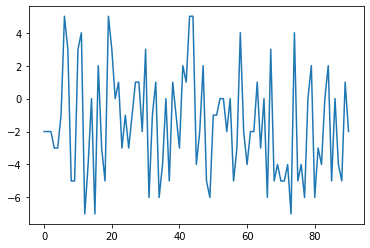

In [145]:
plt.plot(rewards)

In [146]:
n=20
rewards_per_n_episodes = np.split(np.array(rewards),len(rewards)/n)
average_reward_per_n_episodes=[]
for reward_set in rewards_per_n_episodes:
    average_reward_per_n_episodes.append(np.average(reward_set));
    
plt.plot(average_reward_per_n_episodes)

ValueError: array split does not result in an equal division

In [147]:
for e in range(EPISODES):
    state=env.reset()
    episode_rew=0
    for s in range(STEPS):
        
        action = choose_by_epsilon_greedy(env,state,0.5,Q_evaluate)

        reward,next_state,done=env.simulate_action(action)

        replay_memory.store(state,action,reward,next_state)

        state_sample,action_sample,reward_sample,next_state_sample=replay_memory.sample()

        q_values_next = Q_target.predict(np.array([np.array(next_state_sample)]))
        q_values_current =Q_evaluate.predict(np.array([np.array(state_sample)]))
        
        target_sample = reward_sample + np.invert(s==STEPS-1).astype(np.float32) * DISCOUNT_FACTOR * np.amax(q_values_next, axis=1)
        print("curr q=",q_values_current,"target_sample=",target_sample)
        q_values_current[0,env.get_index(action_sample)]=target_sample
        
        Q_evaluate.learn(np.array([state_sample]), q_values_current)
        time.sleep(2)
        print_game()
        state = next_state
        total_steps += 1
        episode_rew+=reward
        if total_steps % STEPS_PER_UPDATE == 0:
            Q_target.set_weights(Q_evaluate)
        
        if done:
            break
    print(e)
    rewards.append(episode_rew)

■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■                 ■ 
■                 ■ 
■                 ■ 
■                 ■ 
■                 ■ 
■ *         ■     ■ 
■                 ■ 
■                 ■ 
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
curr q= [[0. 0. 0. 0.]] target_sample= [1.]
1/1 [==============================] - 0s 2ms/step - loss: 0.2500


KeyboardInterrupt: 